### Load Dependencies

In [1]:
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [2]:
import os
import numpy as np
import opendatasets as od
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from utils import ProgressBar, plot_metrics
import torchvision.models as models

### Load Dataset

In [3]:
# Download Kaggle dataset (Kaggle username and key is required)
# {"username":"christopherconroy","key":"1915e76943ae798bc236fb7c2de6d28d"}
od.download('https://www.kaggle.com/datasets/grassknoted/asl-alphabet')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: christopherconroy
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:10<00:00, 105MB/s]


In [4]:
# Constants
TEST_DATA_DIR = 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'
TRAIN_DATA_DIR = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [5]:
# Initialize dataset
dataset = torchvision.datasets.ImageFolder(root = TRAIN_DATA_DIR, transform = ToTensor())
num_inputs = np.array(dataset[0][0].numpy().shape).prod()
num_outputs = len(dataset.classes)

# Check for CUDA GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [6]:
def split_dataset(dataset, num_samples, train_split, batch_size, seed = 0):
    '''
    Create training and test data loaders from the given dataset.

    Params:
        dataset = PyTorch Dataset instance for full dataset
        num_samples = Number of samples to use from the full dataset
        train_split = Fraction of train data in train/test split
        batch_size Minibatch size for training
        seed = Random seed for dataset shuffle and split. Set to None for no seed.

    Returns:
        train_loader = Dataloader for the training samples
        test_loader = Dataloader for the test samples
    '''

    # Perform stratified split of dataset indicies
    train_size = int((num_samples * train_split) // batch_size) * batch_size
    test_size = num_samples - train_size
    dataset_inds = list(range(len(dataset)))
    train_inds, test_inds = train_test_split(dataset_inds, train_size = train_size, test_size = test_size, random_state = seed, stratify = dataset.targets)

    # Create training and test subsets
    train_set = Subset(dataset, train_inds)
    test_set = Subset(dataset, test_inds)

    # Initialize data loader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

    return train_loader, test_loader

### Training Implementation

In [7]:
def train(data_loader, model, loss_func, optimizer):
    # Initialize parameters
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    total_loss = 0
    correct = 0

    # Set mode to training
    model.train()

    # Initialize progress bar
    progress = ProgressBar('Train Progress', len(data_loader))

    # Iterate through batches
    for images, labels in data_loader: 
        # Transfer images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        #images = images.view(-1, num_inputs)
        
        # Forward pass 
        outputs = model(images)
        loss = loss_func(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Optimization
        optimizer.step()

        # Transfer outputs and labels to CPU
        outputs, labels = outputs.cpu(), labels.cpu()
        
        # Compute batch metrics
        total_loss += loss.item()
        pred = torch.max(outputs, 1)[1]
        correct += (pred == labels).sum().numpy()

        # Update progress
        progress.step()

    # Compute metrics for dataset
    total_loss /= num_batches
    accuracy = (correct / size) * 100

    return total_loss, accuracy

In [8]:
def test(data_loader, model, loss_func):
    # Initialize parameters
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    total_loss = 0
    correct = 0

    # Set mode to evaluation
    model.eval()

    # Initialize progress bar
    progress = ProgressBar('Valid Progress', len(data_loader))

    # Iterate through batches
    with torch.no_grad():
        for images, labels in data_loader:
            # Transfer images and labels to GPU
            images, labels = images.to(device), labels.to(device)
            #images = images.view(-1, num_inputs)

            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Transfer outputs and labels to CPU
            outputs, labels = outputs.cpu(), labels.cpu()

            # Compute batch metrics
            total_loss += loss.item()
            pred = torch.max(outputs, 1)[1]
            correct += (pred == labels).sum().numpy()

            # Update progress
            progress.step()
            
    # Compute metrics for dataset
    total_loss /= num_batches
    accuracy = (correct / size) * 100

    return total_loss, accuracy

In [9]:
def train_model(model, train_loader, valid_loader, learning_rate, num_epochs, weight_decay = 0):
    # Initialize training parameters
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

    # Initialize metrics
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []

    # Train model
    for epoch in range(num_epochs):
        # Train and evaluate model
        train_loss, train_accuracy = train(train_loader, model, loss_func, optimizer)
        valid_loss, valid_accuracy = test(valid_loader, model, loss_func)

        # Store epoch metrics
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(valid_loss)
        test_accuracy_list.append(valid_accuracy)

        # Output progress
        print('Epoch {} | Loss = {:.4f} | Train Accuracy = {:.2f}% | Test Accuracy = {:.2f}%'.format(epoch + 1, train_loss, train_accuracy, valid_accuracy))

    return (train_loss_list, train_accuracy_list), (test_loss_list, test_accuracy_list)

GoogLeNet Model

In [10]:
googlenet = models.googlenet(pretrained = True)
googlenet = googlenet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [11]:
train_loader1, valid_loader1 = split_dataset(dataset, 500, 0.8, 1)
train_metrics1, valid_metrics1 = train_model(googlenet, train_loader1, valid_loader1, 0.015, 50)

Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 1 | Loss = 4.3596 | Train Accuracy = 2.25% | Test Accuracy = 4.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 2 | Loss = 3.5590 | Train Accuracy = 7.50% | Test Accuracy = 8.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 3 | Loss = 3.0118 | Train Accuracy = 13.50% | Test Accuracy = 29.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 4 | Loss = 2.2668 | Train Accuracy = 34.00% | Test Accuracy = 40.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 5 | Loss = 1.6144 | Train Accuracy = 5

Final Train Accuracy = 100.00%
Final Test Accuracy  = 70.00%


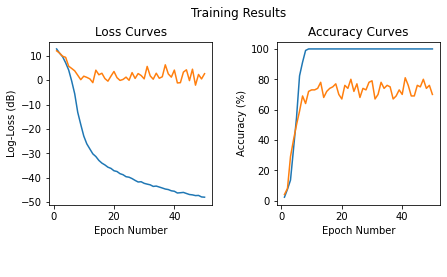

In [12]:
plot_metrics(train_metrics1, valid_metrics1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 1 | Loss = 4.6274 | Train Accuracy = 3.75% | Test Accuracy = 3.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 2 | Loss = 3.8532 | Train Accuracy = 4.25% | Test Accuracy = 6.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 3 | Loss = 3.5295 | Train Accuracy = 7.75% | Test Accuracy = 11.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 4 | Loss = 3.1011 | Train Accuracy = 14.00% | Test Accuracy = 14.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 5 | Loss = 2.6335 | Train Accuracy = 24

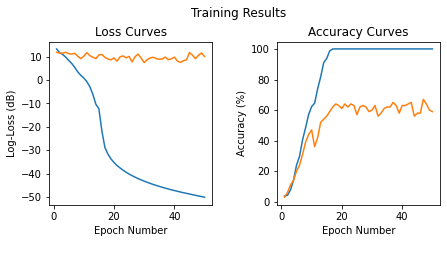

In [18]:
resnet18 = models.resnet18(pretrained = True)
resnet18 = resnet18.to(device)
train_loader2, valid_loader2 = split_dataset(dataset, 500, 0.8, 1)
train_metrics2, valid_metrics2 = train_model(resnet18, train_loader2, valid_loader2, 0.015, 50)
plot_metrics(train_metrics2, valid_metrics2)

In [19]:
vgg16 = models.vgg16(pretrained = True)
vgg16 = vgg16.to(device)
train_loader3, valid_loader3 = split_dataset(dataset, 500, 0.8, 1)
train_metrics3, valid_metrics3 = train_model(vgg16, train_loader3, valid_loader3, 0.01, 50)
plot_metrics(train_metrics3, valid_metrics3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 1 | Loss = nan | Train Accuracy = 3.00% | Test Accuracy = 4.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 2 | Loss = nan | Train Accuracy = 3.25% | Test Accuracy = 4.00%


KeyboardInterrupt: ignored

In [17]:
alexnet = models.alexnet(pretrained = True)
alexnet = alexnet.to(device)
train_loader4, valid_loader4 = split_dataset(dataset, 500, 0.8, 1)
train_metrics4, valid_metrics4 = train_model(alexnet, train_loader4, valid_loader4, 0.01, 50)
plot_metrics(train_metrics4, valid_metrics4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 1 | Loss = 5.2372 | Train Accuracy = 4.00% | Test Accuracy = 3.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 2 | Loss = 3.7467 | Train Accuracy = 4.50% | Test Accuracy = 9.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 3 | Loss = 3.3532 | Train Accuracy = 10.25% | Test Accuracy = 9.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 4 | Loss = 3.3072 | Train Accuracy = 16.25% | Test Accuracy = 25.00%
Train Progress: |████████████████████████████████████████| 100.0%
Valid Progress: |████████████████████████████████████████| 100.0%
Epoch 5 | Loss = 2.9909 | Train Accuracy = 23

KeyboardInterrupt: ignored